## Step 1: import the necessary packages

The first thing to start out our program is to import the necessary packages for the simulation. `numpy` is needed for the basic numerical operations and constants like $\pi$. For visualization, animation and general plotting, we need `matplotlib`. For further optimization and linear algebra tools, we need `scipy`. If you have not installed these libraries yet, you can do so by typing in your terminal:

`pip install matplotlib`

And so on.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from matplotlib.patches import Rectangle
from scipy.sparse import lil_matrix, csc_matrix
from scipy.sparse.linalg import splu
from matplotlib.animation import PillowWriter, FFMpegWriter

Matplotlib is building the font cache; this may take a moment.


## Step 2: Definine the initial Gaussian wavepacket

Solving the Schrodinger's equation requires initial conditions. Here, we give the initial shape of the Gaussian wavepacket, which is centered around $x_0$ and $y_0$. In this part of the program, we are simply creating the function that produces that wavepacket with a given pair $x_0, y_0$.

The initial wavepacket is defined as $\psi_o (x, y) = \exp \left[ \frac{(x - x_0)^2 + (y - y_0)^2}{2\sigma^2}\right] \exp \left[ ik ( x - x_0)\right]$

In [2]:
def psi0(x, y, x0, y0, sigma=0.5, k=15*np.pi):
    return np.exp(-0.5*((x-x0)**2 + (y-y0)**2)/sigma**2) * np.exp(1j*k*(x-x0))

## Step 3: Define the simulation parameters

Here, $L$ is the length of the simulation box, $\Delta_y$ is the grid step; $N_x$, $N_y$ and $N_t$ are the number of points in the $x, y$ directions and in the time axis. The constants
$r_x = - \frac{\Delta t}{2i(\Delta x)^2}$ and $r_y = - \frac{\Delta t}{2i(\Delta y)^2}$ arise from the Crank-Nicholson numerical method.

In [3]:
L = 8                         # width of the well
Dy = 0.05                     # size of the spatial step
Dt = Dy**2 / 4                # size of the time step
Nx = int(L / Dy) + 1          # number of points in the x spatial direction
Ny = int(L / Dy) + 1          # number of poitns in the y spatial direction
Nt = 500                      # number of time steps
rx = -Dt / (2j * Dy**2)       # constant to simplify expressions (Crank-Nicholson's method)
ry = -Dt / (2j * Dy**2)       # same as above

# initial coordinates from the center of Gaussian
x0 = L/5
y0 = L/2

## Step 4: Define the double slit parameters

In [4]:
# Width of the walls, separation between edges and aperture of slits
w, s, a = 0.2, 0.8, 0.4

# Indices that parametrize the double slit in the space ofpoints
# Horizontal axis
j0 = int(1/(2*Dy)*(L-w))
j1 = int(1/(2*Dy)*(L+w))

# Vertical axis
i0 = int(1/(2*Dy)*(L+s) + a/Dy)
i1 = int(1/(2*Dy)*(L+s))
i2 = int(1/(2*Dy)*(L-s))
i3 = int(1/(2*Dy)*(L-s) - a/Dy)

# potential
v = np.zeros((Ny, Ny), dtype=complex)

# number of unknown factors
Ni = (Nx-2)*(Ny-2)

## Step 5: Sparse matrix construction

In [5]:
A = lil_matrix((Ni, Ni), dtype=complex)
M = lil_matrix((Ni, Ni), dtype=complex)

for k in range(Ni):
    i = 1 + k // (Ny - 2)
    j = 1 + k % (Ny - 2)

    # filling out the main diagonal
    A[k, k] = 1 + 2*rx + 2*ry + 1j*Dt/2*v[i, j]
    M[k, k] = 1 - 2*rx - 2*ry - 1j*Dt/2*v[i, j]

    # lower diagonal
    if i != 1:
        A[k, (i-2)*(Ny-2)+j-1] = -ry
        M[k, (i-2)*(Ny-2)+j-1] = ry
    # upper diagonal   
    if i != Nx-2:
        A[k, i*(Ny-2)+j-1] = -ry
        M[k, i*(Ny-2)+j-1] = ry
    # lower main diagonal
    if j != 1:
        A[k, k-1] = -rx
        M[k, k-1] = rx
    # upper main diagonal
    if j != Ny-2:
        A[k, k+1] = -rx
        M[k, k+1] = rx

# coverting to sparse matrix
Asp = A.tocsc()
M = M.tocsc()

# LU decomposition of sparse square matrix
lu = splu(Asp)

    

## Step 6: Meshgrid for initialization and initial wavefunction

In [6]:
x = np.linspace(0, L, Ny-2)
y = np.linspace(0, L, Ny-2)
x, y = np.meshgrid(x, y)

# initializing the wavefunction with the Gaussian
psi = psi0(x, y, x0, y0)

# setting the wavefunction to zero at the boundaries of the simulation box 
psi[0, :] = psi[-1, :] = psi[:, 0] = psi[:, -1] = 0

## Step 7: apply slit mask

In [7]:
# adding the double slit mask, canceling the wavefunction inside the walls of the double slit
slit_mask = np.ones((Nx-2, Ny-2), dtype=bool)
slit_mask[0:i3, j0:j1] = False
slit_mask[i2:i1, j0:j1] = False
slit_mask[i0:, j0:j1] = False
psi *= slit_mask

## Step 8: Perform time-evolution of the wave packet

In [8]:
# Initializing the array that stores the psi(x,y) for every time step t as zeroes
psis = np.zeros((Nt, Nx-2, Ny-2), dtype=complex)
psis[0] = psi

for i in range(1, Nt):
    psi_vect = psi.reshape(Ni)
    b = M @ psi_vect
    psi_vect = lu.solve(b)
    psi = psi_vect.reshape((Nx-2, Ny-2))
    psi *= slit_mask
    psis[i] = psi

# Modulus of the wavefunctions
mod_psis = np.abs(psis)

[]

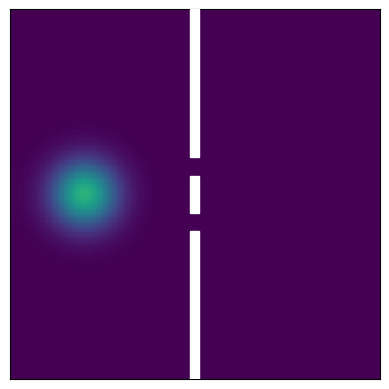

In [9]:
fig = plt.figure()
ax = fig.add_subplot(111, xlim=(0, L), ylim=(0, L))
img = ax.imshow(mod_psis[0], extent=[0, L, 0, L], cmap="viridis", vmin=0, vmax=np.max(mod_psis), interpolation="none")


# Defining the three parts of the wall 
wall_bottom = Rectangle((j0*Dy, 0), w, i3*Dy, color="w", zorder=50)
wall_middle = Rectangle((j0*Dy, i2*Dy), w, (i1-i2)*Dy, color="w", zorder=50)
wall_top    = Rectangle((j0*Dy, i0*Dy), w, i3*Dy, color="w", zorder=50)
ax.add_patch(wall_bottom)
ax.add_patch(wall_middle)
ax.add_patch(wall_top)

# Removing the axes labels and ticks
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_xticks([])
ax.set_yticks([])


In [ ]:
from matplotlib.animation import PillowWriter, FFMpegWriter

def animate(i):
    img.set_data(mod_psis[i])
    return img,

anim = FuncAnimation(fig, animate, interval=1, frames=np.arange(0, Nt, 2), repeat=True, blit=0)
#cbar = fig.colorbar(img)


import os
output_dir = os.getcwd()
gif_path = os.path.join(output_dir, "double_slit_simulation.gif")
mp4_path = os.path.join(output_dir, "double_slit_simulation.mp4")

# Save it as a gif file
anim.save(gif_path, writer=PillowWriter(fps=30))

plt.show()

FileNotFoundError: [Errno 2] No such file or directory: 'ffmpeg'